<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Brief-Intro" data-toc-modified-id="Brief-Intro-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Brief Intro</a></span></li><li><span><a href="#Voting-Classifiers" data-toc-modified-id="Voting-Classifiers-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Voting Classifiers</a></span><ul class="toc-item"><li><span><a href="#Hard-Voting-Classifier" data-toc-modified-id="Hard-Voting-Classifier-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Hard Voting Classifier</a></span></li><li><span><a href="#Soft-Voting-Classifier" data-toc-modified-id="Soft-Voting-Classifier-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Soft Voting Classifier</a></span></li></ul></li><li><span><a href="#Bagging-and-Pasting" data-toc-modified-id="Bagging-and-Pasting-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Bagging and Pasting</a></span><ul class="toc-item"><li><span><a href="#Basic-Ideas" data-toc-modified-id="Basic-Ideas-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Basic Ideas</a></span></li><li><span><a href="#Scikit-Learn-Implementation" data-toc-modified-id="Scikit-Learn-Implementation-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Scikit-Learn Implementation</a></span></li><li><span><a href="#Out-of-Bag-Evaluation" data-toc-modified-id="Out-of-Bag-Evaluation-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Out-of-Bag Evaluation</a></span></li><li><span><a href="#Random-Patches-and-Random-Subspaces" data-toc-modified-id="Random-Patches-and-Random-Subspaces-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Random Patches and Random Subspaces</a></span></li><li><span><a href="#Random-Forests" data-toc-modified-id="Random-Forests-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Random Forests</a></span><ul class="toc-item"><li><span><a href="#Brief-Intro" data-toc-modified-id="Brief-Intro-4.5.1"><span class="toc-item-num">4.5.1&nbsp;&nbsp;</span>Brief Intro</a></span></li><li><span><a href="#Scikit-Learn-Implementation" data-toc-modified-id="Scikit-Learn-Implementation-4.5.2"><span class="toc-item-num">4.5.2&nbsp;&nbsp;</span>Scikit-Learn Implementation</a></span></li><li><span><a href="#Extra-Trees" data-toc-modified-id="Extra-Trees-4.5.3"><span class="toc-item-num">4.5.3&nbsp;&nbsp;</span>Extra-Trees</a></span></li><li><span><a href="#Feature-Importance" data-toc-modified-id="Feature-Importance-4.5.4"><span class="toc-item-num">4.5.4&nbsp;&nbsp;</span>Feature Importance</a></span></li></ul></li></ul></li><li><span><a href="#Boosting" data-toc-modified-id="Boosting-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Boosting</a></span></li></ul></div>

# Setup

Getting default setup from Previous Chapters:
- Making sure it works both in Python 2 & 3
- Getting common imports
- Inline plotting for Jupyter
- Save Figure Function Setup

In [1]:
# python 2 & 3 support
from __future__ import division, print_function, unicode_literals

# common imports
import numpy as np
import os

# setting random seed
np.random.seed(42)

# matplotlib inline plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# plotting setups
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


# save figure function
PROJECT_ROOT_DIR = 'figures'
CHAPTER_ID = 'ensemble_learning'
FIG_PATH = os.path.join(PROJECT_ROOT_DIR, CHAPTER_ID)

def image_path(fig_id):
    return os.path.join(FIG_PATH, fig_id)


def save_fig(fig_id, tight_layout = True):
    if not os.path.isdir(FIG_PATH):
        os.makedirs(FIG_PATH)
    fig_path = os.path.join(FIG_PATH, fig_id + '.png') # save as png file
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(fig_path, format = 'png', dpi = 300)

# Brief Intro

We will cover most popular Ensemble methods in this chapter:
- Voting
- Bagging and Pasting
    - Random Forest (ensemble of Decision Trees trained primarily using Bagging)
- Boosting
- Stacking

# Voting Classifiers

## Hard Voting Classifier

A very simple/basic way to perform ensemble learning is to aggregate the predictions of each classifier and predict the class that gets the most votes. This majority-vote classifier is called a _hard voting_ classifier.

![hard voting classifier](https://i.stack.imgur.com/W7UmY.png)

Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the best classifier in the ensemble. In fact, even if each classifier is a _weak learner_ (meaning it does only slightly better than random guessing), the ensemble can still be a _string learner_ (achieving high accuracy), provided there are sufficient number of weak learners and they are sufficiently diverse.

This can be illustrated via tossing a slightly biased coin that has 51% chance of coming up heads and 49% chance of coming up tails.

In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000,10) < heads_proba).astype(np.int32)
coin_tosses

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 1],
       [0, 1, 1, ..., 0, 0, 1],
       ...,
       [1, 1, 0, ..., 1, 1, 0],
       [0, 0, 1, ..., 1, 1, 1],
       [0, 1, 0, ..., 0, 1, 1]], dtype=int32)

Saving figure law_of_large_numbers_plot


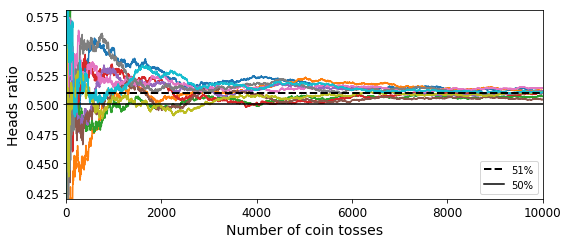

In [3]:
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0)/ np.arange(1, 10001).reshape(-1,1)

plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")

__Note__: <br>
Ensemble methods work best when the predictors are as independent from on another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble's accuracy.

Voting Classifier can be implemented via Scikit-Learn using `VotingClassifier`

----
We can illustrate this using the moon datasets:

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X,y = make_moons(n_samples = 500, noise = 0.30, random_state = 42)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

Now we import multiple classifiers and put them together using voting classifier

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state =42)
rnd_clf = RandomForestClassifier(random_state = 42)
svm_clf = SVC(random_state = 42)

voting_clf = VotingClassifier(estimators = 
                               [('lr', log_clf),
                               ('rf', rnd_clf),
                                ('svc', svm_clf)], 
                              voting = 'hard')

list_classifiers = [log_clf, rnd_clf, svm_clf, voting_clf]

Fitting them through training set & making predictions

In [6]:
# ignore future warnings for scikit learn
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFore...rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

Calculating individual classifier accuracy scores

In [7]:
from sklearn.metrics import accuracy_score

for clf in list_classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


As shown above, the voting classifier slight outperforms all the individual classifiers!

## Soft Voting Classifier

If all classifiers are able to estimate class probabilities (i.e., they have a `predict_proba()` method), then we can tell Scikit-Learn to predict the class with highest class probability, averaged over all the individual classifiers. This is called _soft voting_.

It often achieves higher performance than hard voting because it gives more weight to highly confident votes. All we need to do is to replace `voting = 'hard' ` with `voting = 'soft'` and __ensure all classifiers can estimate class probabilities__.

----
We can use the previous example to illustrate this, but we need to set `SVC(probability = True)` for SVM classifier

In [8]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFore...'rbf', max_iter=-1, probability=True, random_state=42,
  shrinking=True, tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [9]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


As shown above, using soft voting can get a better result than hard voting

# Bagging and Pasting

## Basic Ideas

Another approach for getting a diverse set of classifiers is to use the same training algorithm for every predictor, but to train them on different random subsets of training set. <br>
- When sampling is performed _with_ replacement, this method is called __bagging__ (short for _bootstrap aggregating_).
- When sampling is performed _without_ replacement, this method is called __pasting__.

Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors. The aggregation function is typically the _statistical mode_ (i.e., the most frequent prediction, just like a hard voting classifier) for classification, or the average for regression. Each individual predictor has a higher bias than if it were trained on the original training set, but aggregation reduces both bias and variance. Generally, the nest result is that the ensemble has a similar bias but a lower variance than a single predictor trained on the original training set.

---
Bagging and Pasting can be implemented with Scikit-Learn using `BaggingClassifier` class or (`BaggingRegressor` for regression). See samples listed below:

## Scikit-Learn Implementation

This example illustrate an ensemble of 500 Decision Tree Classifiers, each trained on 100 training instances randomly sampled from the training set with replacement (an example of bagging, if we want to use pasting, set `bootstrap = False`)

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state = 42), 
                            n_estimators = 500, max_samples = 100, bootstrap = True, n_jobs = -1, random_state = 42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

print(bag_clf)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=100, n_estimators=500, n_jobs=-1, oob_score=False,
         random_state=42, verbose=0, warm_start=False)


In [11]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.904

We can compare this over a single decision tree classifier:

In [12]:
tree_clf = DecisionTreeClassifier(random_state = 42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

print(accuracy_score(y_test, y_pred_tree))

0.856


Then we can visualize results by plotting out decision boundary for both classifier:

In [13]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes = [-1.5, 2.5, -1, 1.5], alpha = 0.5, contour = True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(),x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha = 0.3, cmap = custom_cmap)
    
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap = custom_cmap2, alpha = 0.8)
        
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


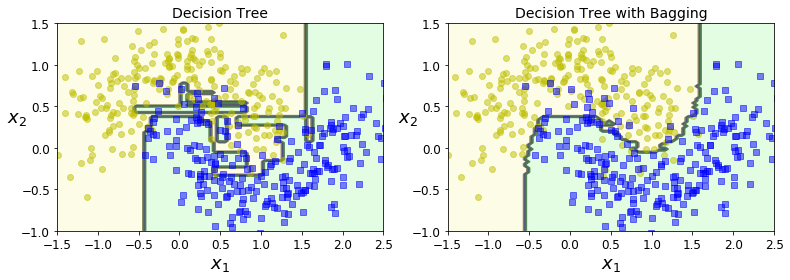

In [14]:
plt.figure(figsize = (11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X,y)
plt.title('Decision Tree', fontsize = 14)

plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title('Decision Tree with Bagging', fontsize = 14)
save_fig('decision_tree_without_and_with_bagging_plot')

As shown above, the ensemble's predictions will likely generalize much better than the single Decision Tree's predictions: the ensemble has a comparable bias but a smaller variance (it makes roughly the same number of errors on the training set, but the decision boundary is less irregular).

__Note__: <br>
The `BaggingClassifier` automatically performs soft voting instead of hard voting if the base classifier can estimate class probabilities (i.e., if it has a `predict_proba()` method), which is the case with Decision Trees classifiers.

Bootstrapping introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting, but it also means that predictors end up being less correlated so the ensemble's variance is reduced. Overall, bagging often results in better models, which explains why it is generally preferred.

## Out-of-Bag Evaluation

With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. By default, a `BaggingClassifier` samples $m$ training instances with replacement (`bootstrap = True`), where $m$ is the size of the training set. This means that only about 63% of the training instances are sampled on average for each predictor ( as $m$ grows, this ratio approaches $ 1- e^\text{-1} \approx 63.212\%$ ). The remaining 37% of the training instances are not sampled are called _out-of-bag_(oob) instances. Note that __they are note the same 37% for all predictors__.

Since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set or cross-validation. You can evaluate the ensemble itself by averaging out the oob evaluations of each predictor.

-----
This can be achieved via `oob_score = True` when creating a `BaggingClassifier` in Scikilt-Learn to request an automatic oob evaluation after training. See illustrations below:

In [15]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state = 42), 
                           n_estimators = 500, bootstrap = True, n_jobs = -1, oob_score = True,
                            random_state = 40
                           )
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

According to the evaluation, this `BaggingClassifier` is likely to achieve about 90.1% accuracy on the test set, we can verify this:

In [16]:
y_pred = bag_clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.912

We got 91.2% v.s. 90.1% accuracy, very close!

The oob Decision Function for each training instances is also available through the `oob_decision_function_` variable. In this case (since the base estimator has a `predict_proba()` method) the decision function returns the class probabilities for each training instance.

In [17]:
bag_clf.oob_decision_function_[0:5]

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

## Random Patches and Random Subspaces

The `BaggingClassifier` class supports sampling the features as well. This is controlled by two hyperparameters: `max_features` and `bootstrap_features`. They work the same way as `max_samples` and `bootstrap`, but for feature sampling instand of instance sampling. Thus each predictor will be trained on a random subset of the input features. 

This is particularly useful when you are dealing with high-dimensional inputs (such as images). Sampling both training instances and features is caleld the _Random Patches_ method. Keeping all training instances (i.e., `bootstrap = False` and `max_samples = 1.0`) but sampling features (i.e., `bootstrap_features = True` and/or `max_features` smaller than 1.0) is called the _Random Subspaces_ method.

## Random Forests

### Brief Intro

As we've discussed, a Random Forest is an ensemble of Decision Trees, generally trained via bagging method (somethings pasting), typically with `max_samples` set to the size of the training set. Instead of building a `BaggingClassifier`， and passing it a `DecisionTreeClassifier`, we can instead use the `RandomForestClassifier` class, which is more convenient and optimized for Decision Trees.

### Scikit-Learn Implementation

See illustrations below for Scikit-Learn implementation for Random Forest:

In [18]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs = -1, random_state = 42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

print(rnd_clf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


A `RandomForestClassifier` has all the hyperparamters of a `DecisionTreeClassifier` (to ctonrol how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself. With a few exceptions:
- `splitter` is absent (forced to `"random"`)
- `presort` is absent(forced to `False`)
- `max_samples` is absent (forced to `1.0`)
- `base_estimator` is absent (forced to `DecisionTreeClassifier` with the provided hyperparameters)

----
We can train a`BaggingClassifier` to illustrate this:

In [19]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(splitter = 'random', max_leaf_nodes = 16, random_state = 42),
                           n_estimators = 500, max_samples = 1.0, bootstrap = True, n_jobs = -1, random_state  = 42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

print(bag_clf)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='random'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=500, n_jobs=-1, oob_score=False,
         random_state=42, verbose=0, warm_start=False)


In [20]:
np.sum(y_pred == y_pred_rf)/len(y_pred) # calculate if predictions are same

0.976

As we can see, this `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model.

### Extra-Trees

When we are growing a tree in a Random Forest, at each node only a random subset of the features is considered for splitting. It is possible to make trees even more random by also using random thresholds for each feature rather than searching for the best possible thresholds.

A forest of such extremely random trees is simply called an _Extremely Randomized Trees_ ensemble (or _Extra-Trees_ for short). Once again, this trades more bias for a lower variance. It also makes Extra-Trees much faster to train than regular Random Forest since finding the best possible threshold for each feature at every node is one of the most time-consuming tasks of growing a tree.

This can be implemented in Scikit-Learn using `ExtraTreesClassifier`, which has identical API to `RandomForestClassifier`. The same goes to `ExtraTreesRegressor`.

__Note__: <br>
It is hard to tell in advance whether a `RandomForestClassifier` will perform better or worse than an `ExtraTreeClassifier`. Generally the only way to know is to try both and compare them using cross-validation (and tuning the hyperparameters using grid search).

### Feature Importance

If we look at a single Decision Tree, important features are likely to appear closer to the root of the tree, while unimportant features will often appear closer to the leaves (or not at all). It is therefore possible to get an estimate of a feature's importance by computing the average depth at which it appears across all threes in the forest. This can be accessed via `feature_importances_` method.

----
Illustrating this using Iris dataset:

In [21]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators = 500, n_jobs = -1, random_state = 42)
rnd_clf.fit(iris['data'], iris['target'])


for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876374
sepal width (cm) 0.023119288282510326
petal length (cm) 0.44103046436395765
petal width (cm) 0.4233579963547681


In [22]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

----
This can also be illustrated using MNIST dataset:

In [23]:
from sklearn.datasets import fetch_mldata
from shutil import copyfileobj
from six.moves import urllib
from sklearn.datasets.base import get_data_home
import os

warnings.simplefilter(action = 'ignore', category = DeprecationWarning) # ignore deprecation warning for fetch_mldata

def fetch_mnist(data_home=None):
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    data_home = get_data_home(data_home=data_home)
    data_home = os.path.join(data_home, 'mldata')
    if not os.path.exists(data_home):
        os.makedirs(data_home)
    mnist_save_path = os.path.join(data_home, "mnist-original.mat")
    if not os.path.exists(mnist_save_path):
        mnist_url = urllib.request.urlopen(mnist_alternative_url)
        with open(mnist_save_path, "wb") as matlab_file:
            copyfileobj(mnist_url, matlab_file)

fetch_mnist()

mnist = fetch_mldata('MNIST original')
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

We can then train a classifier:

In [24]:
rnd_clf = RandomForestClassifier(random_state = 42, n_jobs = -1)
rnd_clf.fit(mnist['data'], mnist['target'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

Plotting digits illustrating feature importances:

Saving figure minst_feature_importance_plot


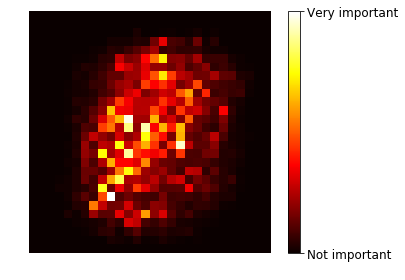

In [25]:
def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image, cmap= matplotlib.cm.hot,
               interpolation = 'nearest'
              )
    plt.axis('off')
    
    
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks = [rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig('minst_feature_importance_plot')

As illustrated above, Random Forests are very hand to get a quick understanding of what features actually matter, in particular if you need to perform feature selection.

# Boosting